# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

# import necessary sklearn modules
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("notebook")

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [32]:
df_merged

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1
...,...,...,...,...,...,...,...,...,...
319,31,December,Champagne,72,89,France,False,Fisher,1
320,32,December,Cabernet Sauvignon,72,45,Germany,True,Young,1
321,32,December,Cabernet Sauvignon,72,45,Germany,True,Cooper,1
322,32,December,Cabernet Sauvignon,72,45,Germany,True,Gomez,1


In [35]:
#your turn

# Merge df_offers and df_transactions on offer_id
df_merged = df_offers.merge(df_transactions, on = 'offer_id')
df_merged.head()

# Use pivot_table to create a table with a row for each customer and a column for each offer
df_merged_pivot = df_merged.pivot_table(index = 'customer_name', columns = 'offer_id', values = 'n', fill_value = 0)
df_merged_pivot

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Wilson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Wood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

>A smaller SS value would indicate better clusterings. The SS value represents the sum of distances from each sample to it's closest cluster center.  The goal would be to minimize this distance.

In [37]:
# Drop the 'customer_name' column to create the matrix of x values to fit the model
x_cols = df_merged_pivot.to_numpy()

# Create a for loop that will create a KMeans model with number of clusters ranging from 2 to 10
k_values = []
model_inertias = []
for i in range(2,11):
    model = KMeans(n_clusters = i, random_state = 1)
    model.fit_predict(x_cols)
    k_values.append(i)
    model_inertias.append(model.inertia_)

# Create a dataframe showing the inertia of the model (sum of squared distances of samples to their closest cluster center) for each value of k
model_inertias_df = pd.DataFrame(data = {'Number of clusters (k)' : k_values, 'Inertia (sum of squares)': model_inertias})
model_inertias_df

,Number of clusters (k),Inertia (sum of squares)
0,2,251.527778
1,3,228.665327
2,4,214.813384
3,5,206.066269
4,6,196.042130
5,7,188.775695
6,8,180.810317
7,9,172.960226
8,10,165.563023


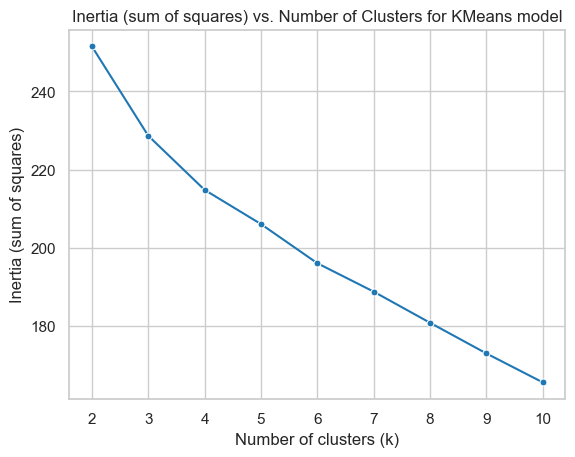

In [38]:
# Create a line plot showing the inertia for each value of k
_ = sns.lineplot(data = model_inertias_df, x = 'Number of clusters (k)', y = 'Inertia (sum of squares)', marker = '.')
plt.setp(_.lines, markersize = 10)
plt.title('Inertia (sum of squares) vs. Number of Clusters for KMeans model')
plt.show()

>From the above plot, it seems like inertia starts to decrease more slowly at k = 4.  So I will use the k = 4 KMeans model.  

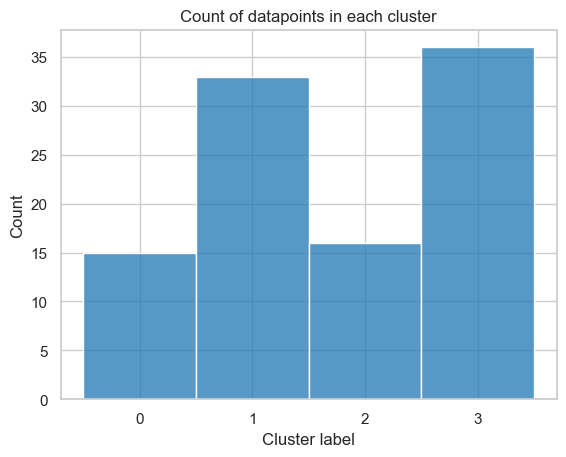

In [39]:
# Create a barchart showing the number of datapoints in each cluster for the k = 4 model

# Create the model
model = KMeans(n_clusters = 4, random_state = 1)
model.fit(x_cols)
cluster_labels = model.predict(x_cols)

# Plot the number of datapoints in each cluster
sns.histplot(data = cluster_labels, discrete = True)
plt.xlabel('Cluster label')
plt.xticks(np.arange(0,4,1))
plt.title('Count of datapoints in each cluster')
plt.show()

>**Challenges with the elbow method:** in this case there really isn't a clear 'elbow'.  Chooking k = 4 feels like a stab in the dark and may not be the best choice.  We'll have to look into this further.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09007566678796264
For n_clusters = 3 The average silhouette_score is : 0.11509635784433903
For n_clusters = 4 The average silhouette_score is : 0.12492443392995986
For n_clusters = 5 The average silhouette_score is : 0.11548564744231736
For n_clusters = 6 The average silhouette_score is : 0.124553236041614
For n_clusters = 7 The average silhouette_score is : 0.14437678821699415
For n_clusters = 8 The average silhouette_score is : 0.1212825987591568
For n_clusters = 9 The average silhouette_score is : 0.11871084808868403
For n_clusters = 10 The average silhouette_score is : 0.1327368468249911


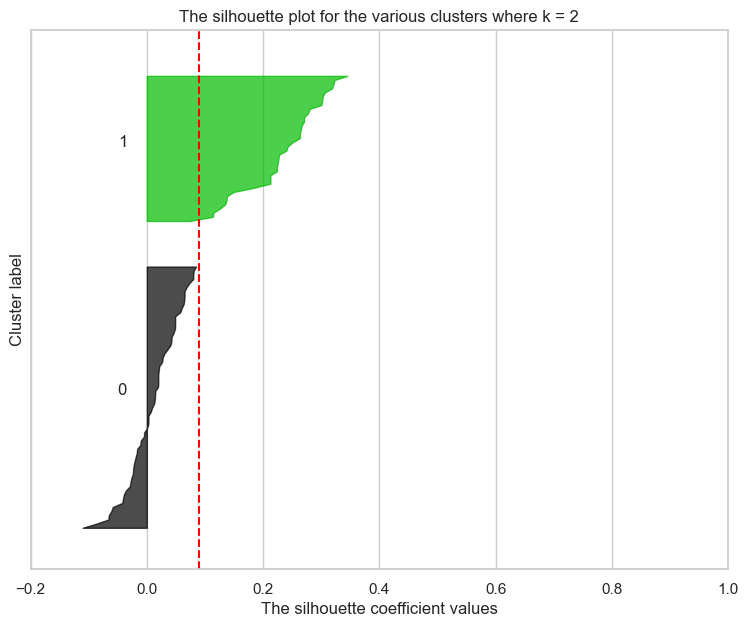

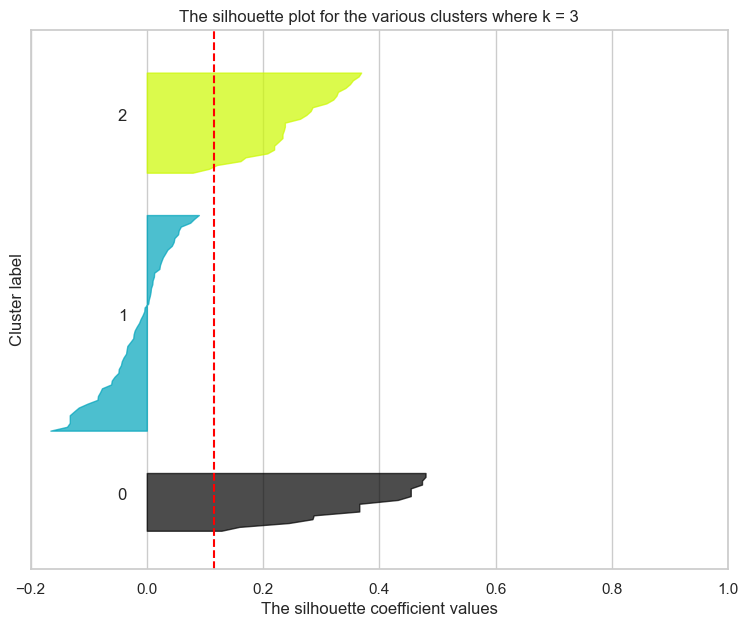

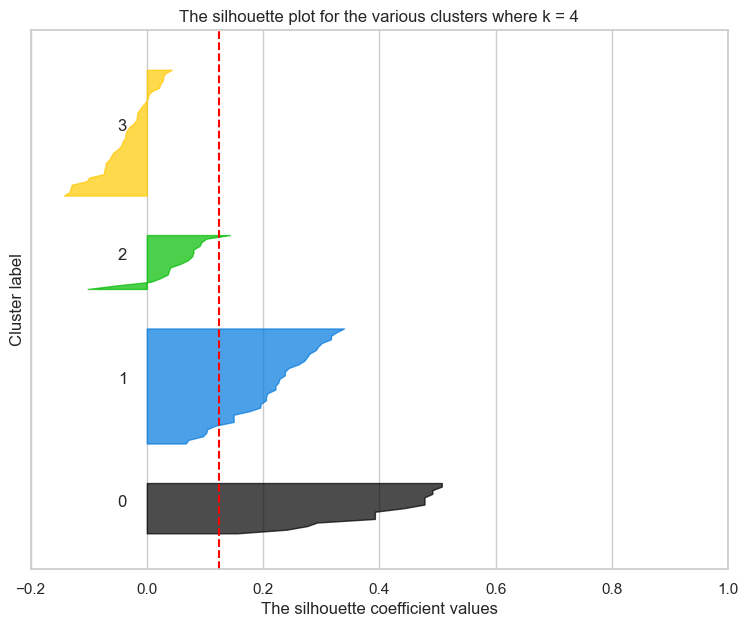

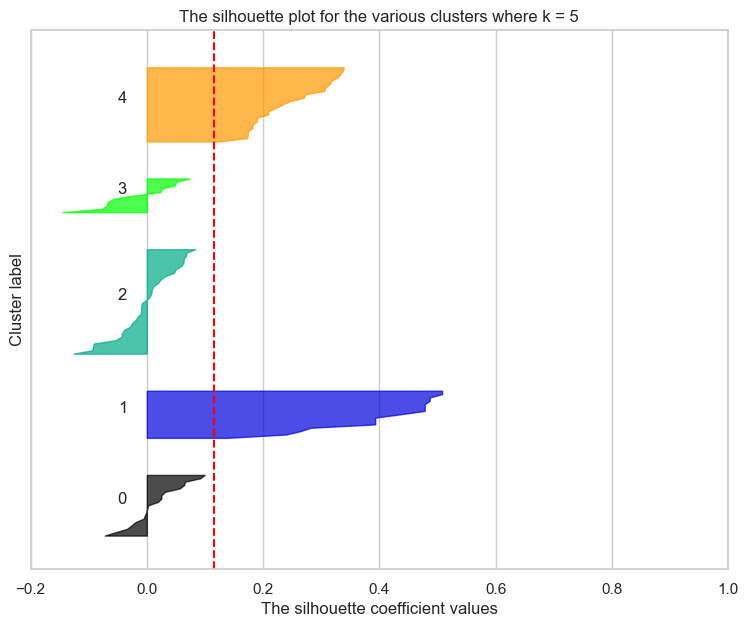

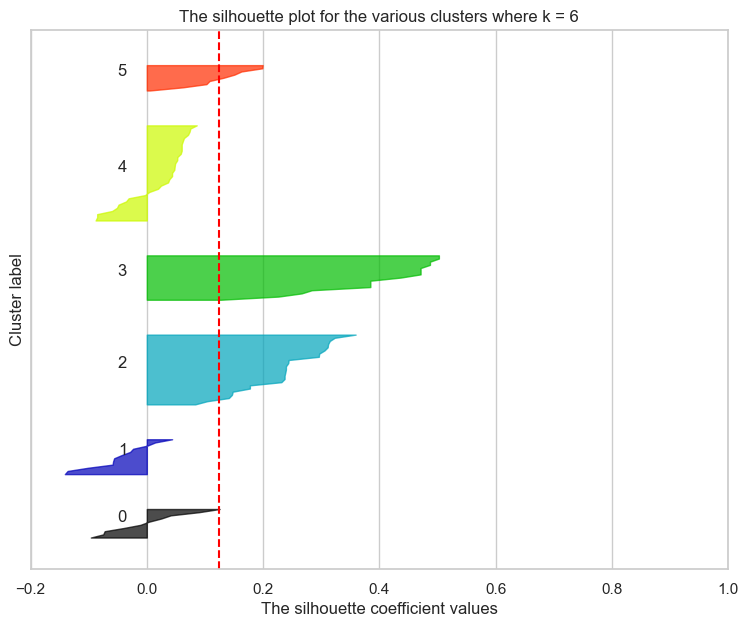

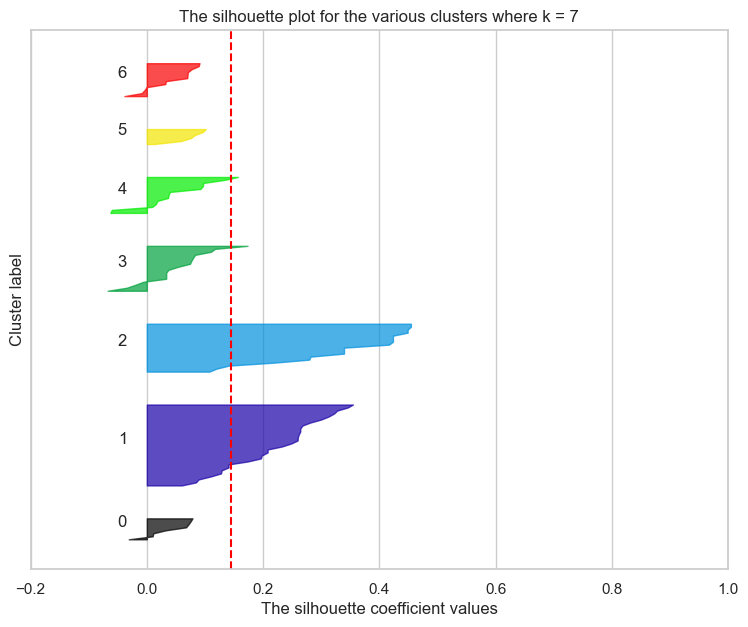

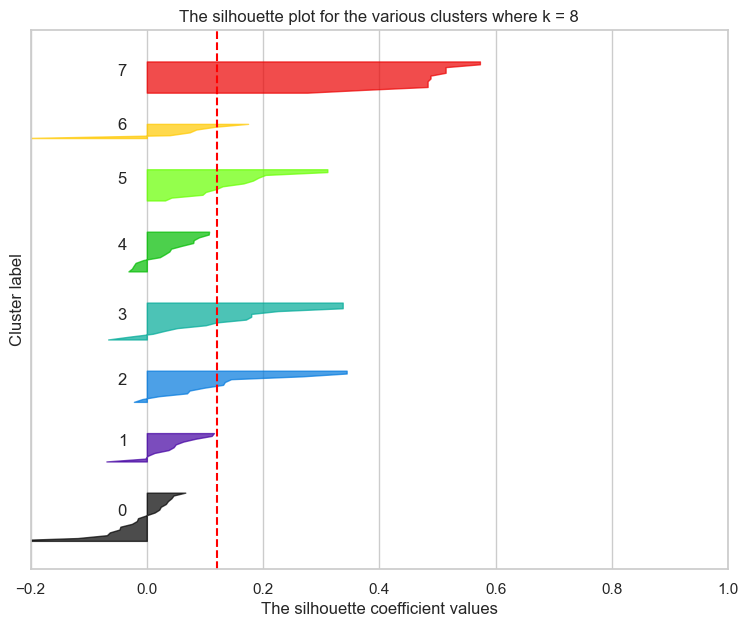

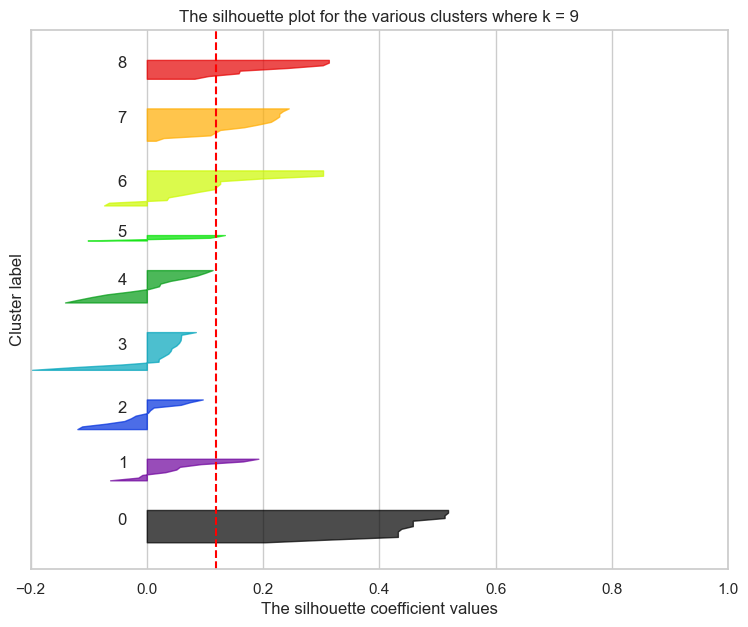

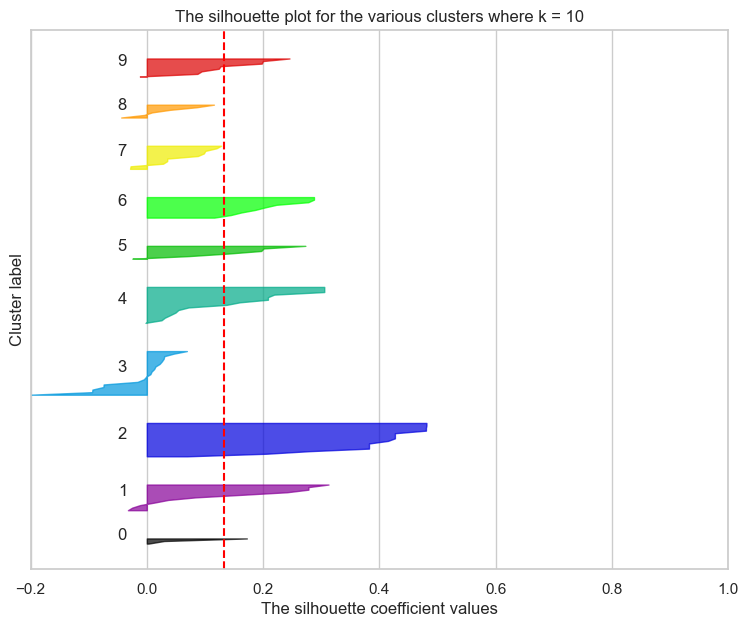

In [40]:
# Rerun the KMeans model for k values between 2 and 10
silhouette_avg_values = []
for i in range(2,11):
    model = KMeans(n_clusters = i, random_state = 1)
    cluster_labels = model.fit_predict(x_cols)

    # Create a subplot
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 7)

    # The silhouette coefficient can range from -1, 1 
    ax.set_xlim([-0.2, 1])
    # The (i+1)*10 is for inserting blank space between silhouette plots of individual clusters to demarcate them clearly.
    ax.set_ylim([0, len(x_cols) + (i + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print(
        "For n_clusters =",
        i,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    silhouette_avg_values.append(silhouette_avg)
    
    # Compute the silhouette score for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for j in range(i):
        # Aggregate the silhouette scores for samples belonging to cluster j, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        jth_cluster_silhouette_values.sort()
        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        color = cm.nipy_spectral(float(j) / i)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            jth_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f"The silhouette plot for the various clusters where k = {i}")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

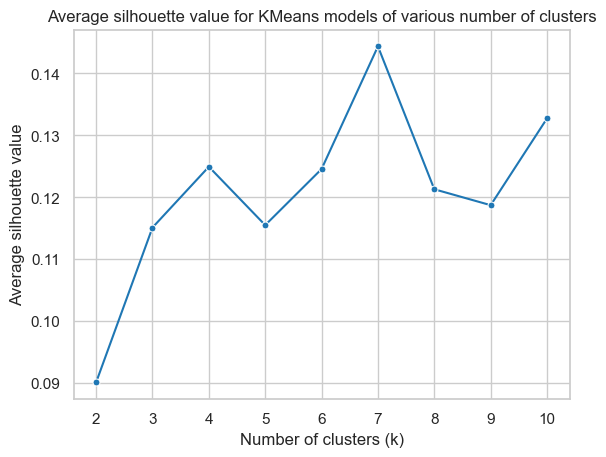

In [41]:
# Plot the silhouette average values for each value of k
_ = sns.lineplot(y = silhouette_avg_values, x = range(2,11), marker = '.')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average silhouette value')
plt.setp(_.lines, markersize = 10)
plt.title('Average silhouette value for KMeans models of various number of clusters')
plt.show()

>Now that we are able to see in more detail how the individual samples relate to their cluster centers, I would be temtped to choose a k=7 instead of the k=4 that was chosen using the elbow method. However, I suspect that this may be too many clusters.  Going from a silhouette value of .09 to .12 is a significant jump and keeping the clusters at 4 may make more sense given the amount of variance that it seems to explain.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [24]:
# Run PCA on the dataframe to reduce dimensions to 2 and convert the result into a df
pca = PCA(n_components = 2, random_state = 1)
pca.fit(x_cols)
transformed = pca.transform(x_cols)
pca_df = pd.DataFrame(transformed, columns = ['pca_X','pca_Y'])

# Run the KMeans model where k = 7 in order to obtain cluster id
model = KMeans(n_clusters = 4, random_state = 1)
model.fit(x_cols)
cluster_labels = model.predict(x_cols)
cluster_df = pd.DataFrame(cluster_labels, columns = ['cluster_id'])

# Create a dataframe with the customer name, cluster id from the KMeans model, and the two PCA components
cluster_pca_df = df_merged_with_dummies.merge(pca_df, left_index = True, right_index = True).merge(cluster_df, left_index = True, right_index = True)[['customer_name','pca_X','pca_Y','cluster_id']]
cluster_pca_df.head()

,customer_name,pca_X,pca_Y,cluster_id
0,Adams,1.007580,0.108215,1
1,Allen,-0.287539,0.044715,3
2,Anderson,-0.392032,1.038391,0
3,Bailey,0.699477,-0.022542,1
4,Baker,0.088183,-0.471695,2


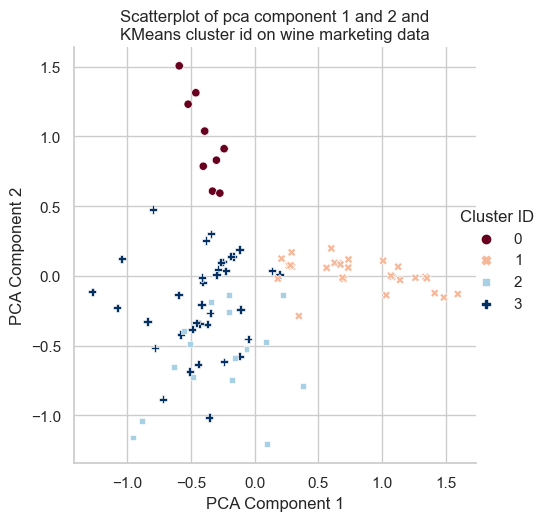

In [55]:
# Run PCA on the dataframe to reduce dimensions to 2 and convert the result into a df
pca = PCA(n_components = 2, random_state = 1)
pca.fit(x_cols)
transformed = pca.transform(x_cols)
pca_X, pca_Y = zip(*transformed)

# Run the KMeans model where k = 4 in order to obtain cluster id
model = KMeans(n_clusters = 4, random_state = 1)
model.fit(x_cols)
cluster_labels = model.predict(x_cols)

# Plot a scatterplot of Y vs. X, colorcoded by cluster id.
_ = sns.set_style('whitegrid')
_ = sns.relplot(kind = 'scatter', x = pca_X, y = pca_Y, hue = cluster_labels, style = cluster_labels, palette = 'RdBu')
_._legend.set_title('Cluster ID')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatterplot of pca component 1 and 2 and\nKMeans cluster id on wine marketing data')
plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

>From the PCA scatterplot it seems as if there are many overlapping samples in the lower left-hand quadrant.  This indicates that we have chosen too many clusters.  From this visual representaion, it seems as if the data may be better represented by 3 clusters instead of 4.
>
>With both the elbow method and the silhouette method, the choice of k was really ambiguous.  I could have easily chosen a larger number of clusters based on either method.  Performing PCA and analyzing the clusters visually is super helpful in determining the best number of clusters to use.

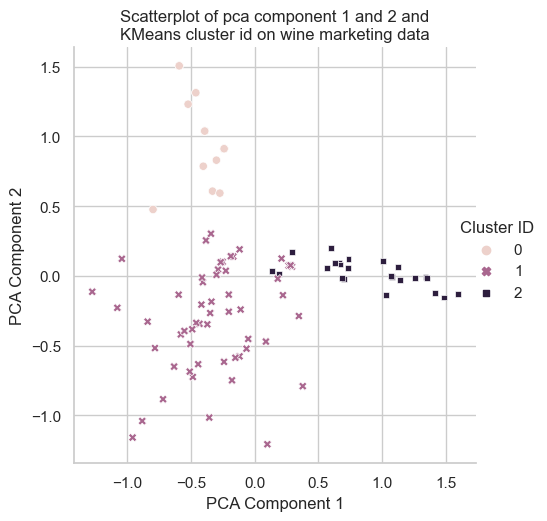

In [54]:
# Recreate the PCA plot with k = 3 KMeans clustering
# Run PCA on the dataframe to reduce dimensions to 2 and convert the result into a df
pca = PCA(n_components = 2, random_state = 1)
pca.fit(x_cols)
transformed = pca.transform(x_cols)
pca_X, pca_Y = zip(*transformed)

# Run the KMeans model where k = 3 in order to obtain cluster id
model = KMeans(n_clusters = 3, random_state = 1)
model.fit(x_cols)
cluster_labels = model.predict(x_cols)

# Plot a scatterplot of Y vs. X, colorcoded by cluster id.
_ = sns.set_style('whitegrid')
_ = sns.relplot(kind = 'scatter', x = pca_X, y = pca_Y, hue = cluster_labels, style = cluster_labels)
_._legend.set_title('Cluster ID')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatterplot of pca component 1 and 2 and\nKMeans cluster id on wine marketing data')
plt.show()

>Lets plot the number of each offer represented in each cluster.  I'll make this easier to visualize by calculating the proportion of each offer in the whole dataset, then showing how that proportion compares to the proportion of each offer represented in the cluster.

In [71]:
pd.DataFrame(proportion_delta, columns = ['proportion_delta']).reset_index()

,offer_id,proportion_delta
0,1,-0.100000
1,2,0.233333
2,3,-0.060000
3,4,-0.120000
4,5,-0.040000
5,6,-0.120000
6,7,-0.190000
7,8,-0.200000
8,9,-0.100000
9,10,-0.070000


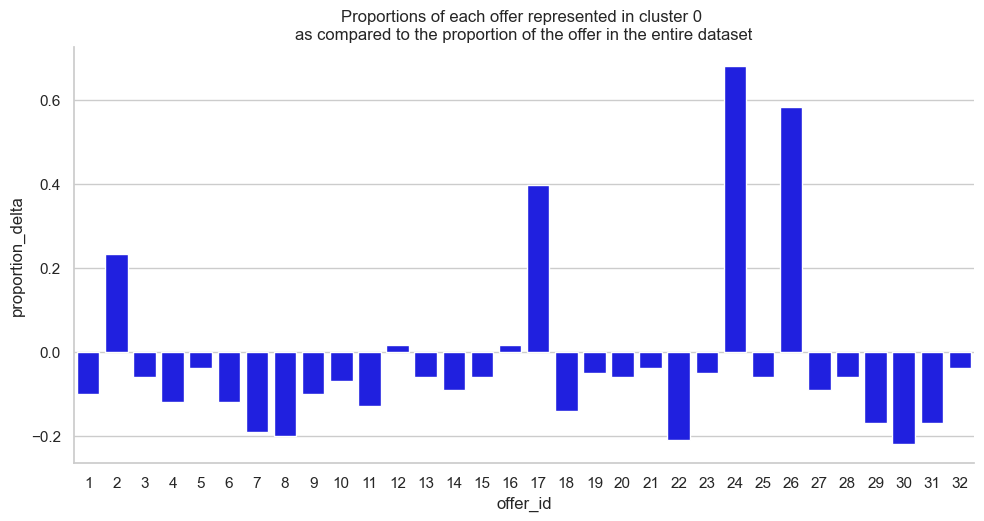

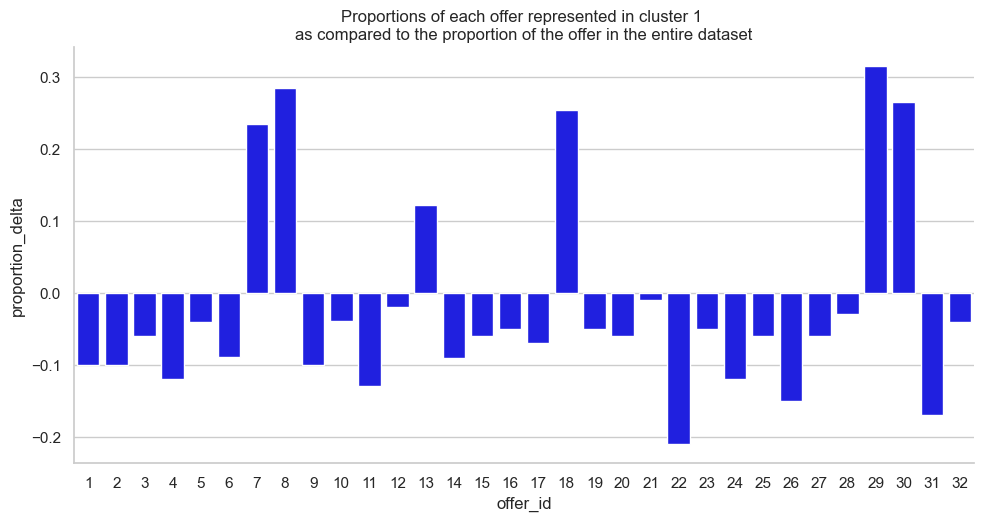

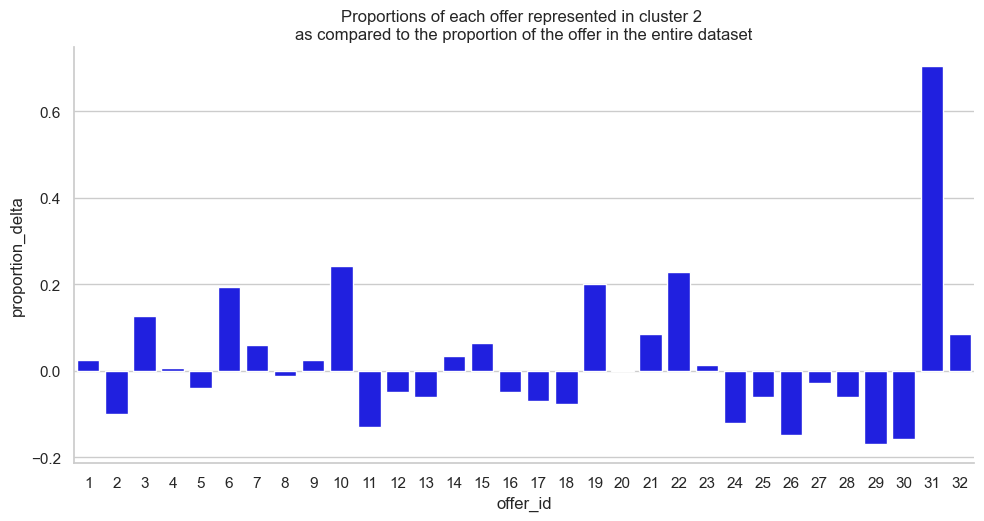

In [76]:
# Calculate the proportion of each offer represented in the entire dataset
offer_proportions_global = df_merged_pivot.sum(axis = 0) / df_merged_pivot.shape[0]

# Calculate the offer proportions for each cluster and  
# then create a barplot for each cluster showing how the proportion of each offer changes in each cluster compared to the global proportion
for i in range(3):
    cluster = df_merged_pivot[cluster_labels == i]
    offer_proportions_cluster = cluster.sum(axis = 0) / cluster.shape[0]
    proportion_delta = offer_proportions_cluster - offer_proportions_global
    proportion_delta_df = pd.DataFrame(proportion_delta, columns = ['proportion_delta']).reset_index()
    _ = sns.catplot(kind = 'bar', y = 'proportion_delta', x = 'offer_id', data = proportion_delta_df, color = 'b', aspect = 2)
    plt.title(f'Proportions of each offer represented in cluster {i} \nas compared to the proportion of the offer in the entire dataset')

>The above graphs are very interesting.  It would be an interesting exercise to delve deeper into these offers and analyze if any of these offers that are disproportional to the global proporation are due to certain characteristics of the wine (e.g., type of wine, past peak, etc). This insight creates a very good jumping off point for further analysis which the marketing team can use going forward.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

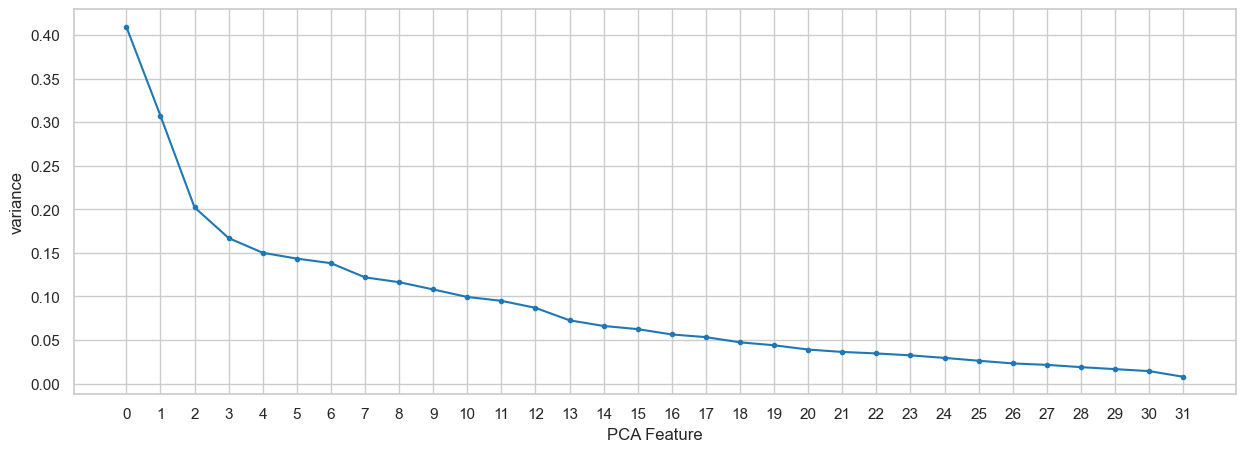

In [88]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
features = range(pca.n_components_)
plt.figure(figsize=(15,5))
plt.plot(features, pca.explained_variance_,marker = '.')
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA Feature')
plt.show()

>Based on the explained variance, 2 components for PCA seems reasonable.  Adding additional components doesn't decrease the variance too much.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

>**Conclusions:** Based on the analysis above, it seems we can group the customers who responded to the marketing offers into three categories.  We've analyzed which offers were strongly represented in each of the categories and can work with the marketing team to further delve into what offer/wine characteristics (e.g., disount, region, date, etc) comprises each of the customer categories.  This will help them develop more targeted offers in the future.

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [103]:
# Affinity propagation
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
AP = AffinityPropagation()
ap = AP.fit(x_cols)

cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_
n_clusters_ = len(cluster_centers_indices)
print("Estimated number of clusters: %d" % n_clusters_)
print("Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(x_cols, labels, metric="sqeuclidean"))

Estimated number of clusters: 14
Silhouette Coefficient: 0.184


In [111]:
# Spectral Clustering
from sklearn.cluster import SpectralClustering
SC = SpectralClustering()
sc = SC.fit(x_cols)


print("Estimated number of clusters: %d" % len(np.unique(sc.labels_)))
print('Silhouette Coefficient: %0.3f' % metrics.silhouette_score(x_cols, sc.labels_, metric = 'sqeuclidean'))

Estimated number of clusters: 8
Silhouette Coefficient: 0.124


In [113]:
# Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
AC = AgglomerativeClustering()
ac = AC.fit(x_cols)

print("Estimated number of clusters: %d" % ac.n_clusters_)
print('Silhouette Coefficient: %0.3f' % metrics.silhouette_score(x_cols, ac.labels_, metric = 'sqeuclidean'))

Estimated number of clusters: 2
Silhouette Coefficient: 0.123


In [148]:
# DBScan
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps = 1.5, min_samples=2)
db = DB.fit(x_cols)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


print("Estimated number of clusters: %d" % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Silhouette Coefficient: %0.3f' % metrics.silhouette_score(x_cols, labels, metric = 'sqeuclidean'))

Estimated number of clusters: 3
Estimated number of noise points: 28
Silhouette Coefficient: 0.152


> Affinity propagation, Spectral clustering, and agglomerative clustering didn't perform very well given the default parameters.  Perhaps the parameters could be tweaked to improve performance  AP and SC both had a large number of clusters even though their silhouette scores were relatively high. Agglomerative clustering only provided two clusters.  DBSCAN, with some tweaking of the parameters was able to provide 3 clusters with a pretty high silhouetter score. Perhaps this model is worth exploring more if it is better able to categorize the customers.